# Practical Portfolio Optimization with Warm-Starting Qubits using QAOA

Before getting into the nitty-gritty of the title, it is important to take each piece of it step by step. By continuing ideas presented in the [Qiskit Textbook](https://qiskit.org/documentation/finance/tutorials/01_portfolio_optimization.html) and the paper [Improving Variational Quantum Optimization using CVaR. Barkoutsos et al. 2019](https://arxiv.org/abs/1907.04769) that experiments this problem on real quantum hardware, I will work out the problem of portfolio optimization, by solving the following problem:
$\begin{split}\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } b \le d^T x \le B
\end{aligned}\end{split}$
where I use the following notation:
* $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
* $d \in \{0, \infty\}^n$ denotes the vector of asset values in dollar amount,
* $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
* $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
* $q > 0$ controls the risk appetite of the decision maker,
* and $b$ denotes the minimum of the budget to be spent and $B$ denotes the budget, i.e. the amount of money to be used to select a number of assets out of $n$.

Firstly, the below modules need to be installed. Since this is a financial problem, the `qiskit_finance` module needs to be imported. Furthermore, since solving this problem involves optimizing for the best possible result, the `qiskit_optimization` module needs to be imported as well.

Through optimization, three different types of algorithms will be used: NumPyMinimumEigensolver, VQE, and QAOA. The first algorithm, NumPyMinimumEigensolver, is a classical algorithm, where its goal is to search over feasible states and return an eigenstate that has the smallest eigenvalue among feasible states. The second algorithm, VQE, also known as Variational Quantum Eigensolver, uses the variational principle to compute the ground state energy of a Hamiltonian. The last algorithm, QAOA, also known as Quantum Approximate Optimization Algorithm, produces approximate solutions for combinatorial optimization problems.

The paper [arXiv:2004.04197: Quantum Approximate Optimization of Non-Planar Graph Problems on a Planar Superconducting Processor](https://arxiv.org/abs/2004.04197) by Google Quantum AI, presented ideas for this project to implement the quantum approximate optimization algorithm (QAOA) on a superconducting qubit quantum processor to combinatorial optimization problems. While it is unclear whether the quantum advantange of QAOA are present, QAOA still prescribes a good and simple paradigm for optimization.

In [1]:
# Import auxiliary libraries
import numpy as np
import datetime
import matplotlib.pyplot as plt
import copy

# Import Qiskit
from qiskit import IBMQ, Aer, QuantumCircuit
from qiskit.algorithms import QAOA, VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance, algorithm_globals

from qiskit_finance.data_providers import RandomDataProvider, YahooDataProvider
from qiskit_finance import QiskitFinanceError

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.problems.variable import VarType

In [2]:
# For large matricies
algorithm_globals.massive = True

### Define problem instance

To begin, I will use random data to demonstrate key concepts of the portfolio optimization process.

In [3]:
# set number of assets (= number of qubits)
num_assets = 3
seed = 123

# Generate expected return and covariance matrix from the random time-series
stocks = [('TICKER%s' % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

In [4]:
print(mu)
print(sigma)

[ 0.01528439 -0.00078095  0.00051792]
[[2.54138859e-03 7.34022167e-05 1.28600531e-04]
 [7.34022167e-05 2.58486713e-04 5.30427595e-05]
 [1.28600531e-04 5.30427595e-05 7.91504681e-04]]


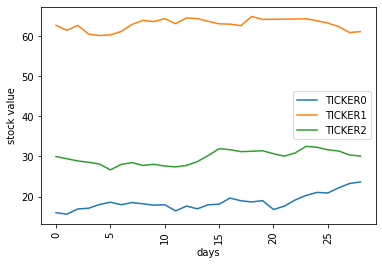

In [5]:
# plot financial data
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('days')
plt.ylabel('stock value')
plt.show()

#### Covariance Matrix $\Sigma$
The covariance matrix is a statistical measure to compare two asset's mean returns as the vary with respect to each other. It further helps to understand the amount of risk involved from the investment portfolio's perspective to make an informed decision about buying or selling stocks.

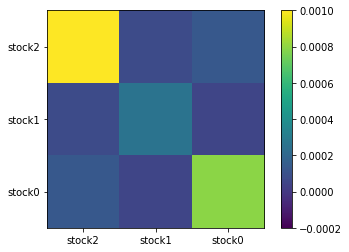

In [6]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
ticks_list = [0, 1, 2]
x_label_list = ['stock2', 'stock1', 'stock0']
y_label_list = ['stock2', 'stock1', 'stock0']
plt.xticks(ticks_list, x_label_list)
plt.yticks(ticks_list, y_label_list)
plt.colorbar()
plt.clim(-0.0002, 0.001)
plt.show()

In [7]:
q = 0.5 # set risk factor
budget = 750 # set budget in dollars
assets = data._tickers # name of assets
asset_costs = np.array([data._data[i][-1] for i in range(len(assets) - 1, -1, -1)]) # costs of asset at end of time period
share_limit = 3 # max number of shares to buy per stock
minimum_spending = 75 # minimum amount of budget to be spent

#### Portfolio Quadratic Program
To create the problem specified earlier, this function takes in all of the required arguments to convert them into a quadratic program. In addition to $\mu$ (the expected returns), and $\Sigma$ (the covariance matrix), the following variables are also taken into account to give a potential investor a high level of flexibility:
* Risk Factor – how big of a risk the investor is willing to take.
* Budget – the $$$ amount the investor is willing to use to invest in stocks.
* Stock Tickers – which stocks (i.e. AAPL, GOOG, TSLA, etc.) the investor would like to invest in.
* Minimum Spending – the $$$ amount the investor wants to spend at the minimum when investing.
* Share Limit – the maximum number of shares the investor would like to buy per stock ticker.

Importantly, since introducing many other factors, along with account for the dollar amounts of each asset, the quadratic program simplifies the budget and asset values based on the asset of least value. Depending on the this value, the budget, minimum spending, and each of the asset costs will be divided by $10^n$, where $n$ is the power-of-10 notation's exponent for the least valued asset.

In [8]:
def portfolio_quadratic_program(expected_returns: np.ndarray or list, covariances: np.ndarray or list, risk_factor: int or float, budget: int or float, assets: np.ndarray or list, \
                                asset_costs: np.ndarray or list, share_limit: int = 1, minimum_spending: int or float = 0):
    assert type(expected_returns) == np.ndarray or list, 'expected_returns must be numpy.ndarray or list'
    assert type(covariances) == np.ndarray or list, 'covariances must be numpy.ndarray or list'
    assert type(risk_factor) == int or float, 'risk_factor must be int or float'
    assert type(budget) == int or float, 'budget must be int or float'
    assert type(assets) == np.ndarray or list, 'assets must be numpy.ndarray or list'
    assert type(asset_costs) == np.ndarray or list, 'asset_costs must be numpy.ndarray or list'
    assert type(share_limit) == int, 'share_limit must be int'
    assert type(minimum_spending) == int or float, 'minimum_spending must be int or float'
    
    # Simplify the floats to decrease the number of qubits while still maintaining an accurate result
    least_expense_asset = np.min(asset_costs)
    cost_simplifier = 1
    if least_expense_asset >= 10:
        cost_simplifier_i = 1
        while least_expense_asset // (10 ** cost_simplifier_i) != 0:
            cost_simplifier_i += 1
        cost_simplifier = 10 ** (cost_simplifier_i - 1)

    quad_budget = budget // cost_simplifier
    quad_minimum_spending = minimum_spending // cost_simplifier
    quad_asset_costs = np.array([ac // cost_simplifier for ac in asset_costs])

    portfolio = QuadraticProgram(name='Portfolio')

    portfolio.integer_var_dict(keys=assets, lowerbound=0, upperbound=share_limit)
    portfolio.minimize(
        linear=expected_returns,
        quadratic=covariances * risk_factor
    )
    portfolio.linear_constraint(linear=quad_asset_costs, sense='<', rhs=quad_budget)
    if minimum_spending > 0:
        portfolio.linear_constraint(linear=quad_asset_costs, sense='>', rhs=quad_minimum_spending)

    return portfolio

In [9]:
qp = portfolio_quadratic_program(
    expected_returns=mu,
    covariances=sigma,
    risk_factor=q,
    budget=budget,
    assets=assets,
    asset_costs=asset_costs,
    share_limit=share_limit,
    minimum_spending=minimum_spending
)
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio

Minimize
 obj: 0.015284386652 xTICKER0 - 0.000780952145 xTICKER1
      + 0.000517920547 xTICKER2 + [ 0.002541388592 xTICKER0^2
      + 0.000146804433 xTICKER0*xTICKER1 + 0.000257201062 xTICKER0*xTICKER2
      + 0.000258486713 xTICKER1^2 + 0.000106085519 xTICKER1*xTICKER2
      + 0.000791504681 xTICKER2^2 ]/2
Subject To
 c0: 3 xTICKER0 + 6 xTICKER1 + 2 xTICKER2 <= 75
 c1: 3 xTICKER0 + 6 xTICKER1 + 2 xTICKER2 >= 7

Bounds
       xTICKER0 <= 3
       xTICKER1 <= 3
       xTICKER2 <= 3

Generals
 xTICKER0 xTICKER1 xTICKER2
End

In [10]:
qubo = QuadraticProgramToQubo().convert(qp)
qubo

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio

Minimize
 obj: - 525.542263199492 xTICKER0@0 - 1051.084526398984 xTICKER0@1
      - 1051.115876124432 xTICKER1@0 - 2102.231752248864 xTICKER1@1
      - 350.371180470216 xTICKER2@0 - 700.742360940431 xTICKER2@1
      - 160.230959629922 c0@int_slack@0 - 320.461919259844 c0@int_slack@1
      - 640.923838519687 c0@int_slack@2 - 1281.847677039375 c0@int_slack@3
      - 2563.695354078749 c0@int_slack@4 - 5127.390708157498 c0@int_slack@5
      - 1922.771515559062 c0@int_slack@6 + 14.954889565459 c1@int_slack@0
      + 29.909779130919 c1@int_slack@1 + 59.819558261837 c1@int_slack@2
      + 119.639116523675 c1@int_slack@3 + 164.503785220053 c1@int_slack@4 + [
      38.457971699773 xTICKER0@0^2 + 153.831886799093 xTICKER0@0*xTICKER0@1
      + 153.821868049158 xTICKER0@0*xTICKER1@0
      + 307.643736098317 xTICKER0@0*xTICKER1@1
      + 51.274164282637 xTICKER0@0*xTICKER2@0
      + 102.548328565273 xTICKER0@0

#### Convert Quadratic Program
To estimate how many qubits the quadratic program will require, it can be converted to an Ising Model. This is a very crucial step because the number of computational power needed increases exponentially with every additional qubit on a classical machine. To combat this, I check the number of required qubits in the circuit and minimize it to be able to simulate the circuit in a reasonable amount of time.

In [11]:
ising_operations, _ = (
    qubo
    .to_ising()
)
num_qubits = ising_operations.num_qubits
print(f'Number of qubits required is {ising_operations.num_qubits}.')

Number of qubits required is 18.


#### Helper Functions
The first function is to convert the result from solving a QUBO, or Quadratic Unconstrained Binary Optimization, into a more readable format. The following two result printer functions display the final results as number of shares and the amount of budget used to purchase the specified shares.

In [12]:
def convert_qubo_result(result, names, share_limit):
    converted_result = {}
    share_lim_binary = len(np.binary_repr(share_limit))
    result_x = np.round(result.x)
    for i, e in enumerate(names):
        result_i = list(reversed(result_x[i*share_lim_binary:(i+1)*share_lim_binary]))
        result_i = [str(int(e_ij)) for e_ij in result_i]
        result_i = ''.join(result_i)
        converted_result[e] = int(result_i, 2)
    return converted_result 

def print_result(result, budget, qp: QuadraticProgram, asset_costs: np.ndarray):
    print(f'Solution found with a ${budget:,.2f} budget:\n')
    total_cost = np.dot(result.x, asset_costs.T)
    print(f'Total cost of assets to buy is ${total_cost:,.2f}')
    print(f'Stocks to buy are: ')
    _stocks = [v.name for v in qp.variables]
    for stockIndex, stockShares in enumerate(result.x):
        print(f'\t{stockShares} shares of {_stocks[stockIndex]} at ${asset_costs[stockIndex]:,.2f} per share')

def print_converted_result(converted_result, budget, asset_costs):
    print(f'Solution found with a ${budget:,.2f} budget:\n')
    result_x = np.array(list(converted_result.values()))
    total_cost = np.dot(result_x, asset_costs.T)
    print(f'Total cost of assets to buy is ${total_cost:,.2f}')
    print(f'Stocks to buy are: ')
    _stocks = list(converted_result.keys())
    for stockIndex, stockShares in enumerate(result_x):
        print(f'\t{stockShares} shares of {_stocks[stockIndex]} at ${asset_costs[stockIndex]:,.2f} per share')

#### Classical Simulation
This first problem on random data is solved using the Numpy Minimum Eigensolver algorithm. Using this solver coupled with the Minimum Eigen Optimizer solves the problem specified earlier classically.

In [13]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qubo)
result

optimal function value: -0.0011796662265624036
optimal value: [0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1.]
status: SUCCESS

In [14]:
converted_result = convert_qubo_result(result, ['stock1', 'stock2', 'stock3'], share_limit)
print_converted_result(converted_result, budget, asset_costs)

Solution found with a $750.00 budget:

Total cost of assets to buy is $183.21
Stocks to buy are: 
	0 shares of stock1 at $30.10 per share
	3 shares of stock2 at $61.07 per share
	0 shares of stock3 at $23.66 per share


### Solution using VQE
The below solution is using the Variational Quantum Eigensolver. However, since the circuit takes a very long time to simulate, the output will not be shown. Please continue reading to see its later implementation.

In [15]:
# algorithm_globals.random_seed = 1234
# backend = Aer.get_backend('qasm_simulator')

# cobyla = COBYLA()
# cobyla.set_options(maxiter=200)
# ry = TwoLocal(num_qubits=num_qubits, rotation_blocks='ry', entanglement_blocks='cz', reps=1, entanglement='full')
# qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
# vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=qi)
# vqe = MinimumEigenOptimizer(vqe_mes)
# vqe_result = vqe.solve(qp)

#### Solution using QAOA
The below solution is using the Quantum Approximate Optimization Algorithm. The below solution is using the Variational Quantum Eigensolver. However, since the circuit takes a very long time to simulate, the output will not be shown. Please continue reading to see its later implementation.

In [16]:
# algorithm_globals.random_seed = 1234
# backend = Aer.get_backend('qasm_simulator')

# cobyla = COBYLA()
# cobyla.set_options(maxiter=200)
# qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
# qaoa_mes = QAOA(optimizer=cobyla, reps=1, quantum_instance=qi)
# qaoa = MinimumEigenOptimizer(qaoa_mes)
# qaoa_result = qaoa.solve(qp)

## Testing on real data
Using the data from Yahoo Finance, this method can be tested to see how well it might do practically.

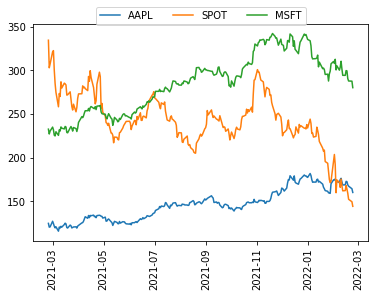

In [17]:
stock_tickers = ['AAPL', 'SPOT', 'MSFT']
data = None
try:
    data = YahooDataProvider(
        tickers=stock_tickers,
        start=datetime.datetime(2021, 2, 24),
        end=datetime.datetime(2022, 2, 24)
    )
    data.run()
    for (cnt, s) in enumerate(data._tickers):
        plt.plot(data._data[cnt], label=s)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.xticks(rotation=90)
    plt.show()
except QiskitFinanceError as ex:
    data = None
    print(ex)

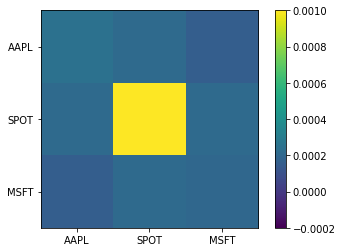

In [18]:
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

# plot sigma
plt.imshow(sigma, interpolation="nearest")
ticks_list = [0, 1, 2]
x_label_list = stock_tickers
y_label_list = stock_tickers
plt.xticks(ticks_list, x_label_list)
plt.yticks(ticks_list, y_label_list)
plt.colorbar()
plt.clim(-0.0002, 0.001)
plt.show()

In [19]:
q = 0.5 # set risk factor
budget = 750 # set budget in dollars
assets = data._tickers # name of assets
asset_costs = np.array([data._data[i][-1] for i in range(len(assets) - 1, -1, -1)]) # costs of asset at end of time period
share_limit = 2 # max number of shares to buy per stock
minimum_spending = 500 # minimum amount of budget to be spent

In [20]:
qp = portfolio_quadratic_program(
    expected_returns=mu,
    covariances=sigma,
    risk_factor=q,
    budget=budget,
    assets=stock_tickers,
    asset_costs=asset_costs,
    share_limit=share_limit,
    minimum_spending=minimum_spending
)
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio

Minimize
 obj: 0.001118223807 xAAPL - 0.002818408323 xSPOT + 0.000838751803 xMSFT + [
      0.000249827641 xAAPL^2 + 0.000425622789 xAAPL*xSPOT
      + 0.000315640009 xAAPL*xMSFT + 0.001028629977 xSPOT^2
      + 0.000429502598 xSPOT*xMSFT + 0.000199558183 xMSFT^2 ]/2
Subject To
 c0: 2 xAAPL + xSPOT + xMSFT <= 7
 c1: 2 xAAPL + xSPOT + xMSFT >= 5

Bounds
       xAAPL <= 2
       xSPOT <= 2
       xMSFT <= 2

Generals
 xAAPL xSPOT xMSFT
End

In [21]:
qubo = QuadraticProgramToQubo().convert(qp)

In [22]:
ising_operations, _ = (
    qubo
    .to_ising()
)
num_qubits = ising_operations.num_qubits
print(f'Number of qubits required is {ising_operations.num_qubits}.')

Number of qubits required is 11.


In [23]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qubo)

In [24]:
converted_result = convert_qubo_result(result, stock_tickers, share_limit)

In [25]:
print_converted_result(converted_result, budget, asset_costs)

Solution found with a $750.00 budget:

Total cost of assets to buy is $1,313.19
Stocks to buy are: 
	2 shares of AAPL at $280.27 per share
	3 shares of SPOT at $144.17 per share
	2 shares of MSFT at $160.07 per share


### Solution with continuous relaxation
Continuous-valued relaxation can be used to initialize quantum-classical hybrid algorithms. This is also known as warm-starting them. However, more on this later. The purpose of this function below is to convert the variables to be continuous instead of binary so then they can be leverged for warm-start quantum optimization algorithms.

In [26]:
def relax_problem(qp: QuadraticProgram) -> QuadraticProgram:
    '''Change all variables to continuous'''
    relaxed_problem = copy.deepcopy(qp)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem

In [27]:
relaxed_qubo = relax_problem(qubo)
relaxed_qubo

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio

Minimize
 obj: - 48.711601628890 xAAPL@0 - 48.711601628890 xAAPL@1
      - 24.359178334672 xSPOT@0 - 24.359178334672 xSPOT@1
      - 24.355521174545 xMSFT@0 - 24.355521174545 xMSFT@1
      - 14.207876623703 c0@int_slack@0 - 28.415753247407 c0@int_slack@1
      - 56.831506494813 c0@int_slack@2 + 10.148483302645 c1@int_slack@0
      + 20.296966605290 c1@int_slack@1 + [ 16.237823111873 xAAPL@0^2
      + 32.475646223747 xAAPL@0*xAAPL@1 + 16.237998907022 xAAPL@0*xSPOT@0
      + 16.237998907022 xAAPL@0*xSPOT@1 + 16.237888924241 xAAPL@0*xMSFT@0
      + 16.237888924241 xAAPL@0*xMSFT@1 + 8.118786642116 xAAPL@0*c0@int_slack@0
      + 16.237573284232 xAAPL@0*c0@int_slack@1
      + 32.475146568465 xAAPL@0*c0@int_slack@2
      - 8.118786642116 xAAPL@0*c1@int_slack@0
      - 16.237573284232 xAAPL@0*c1@int_slack@1 + 16.237823111873 xAAPL@1^2
      + 16.237998907022 xAAPL@1*xSPOT@0 + 16.237998907022 xAAPL@1*xSPOT

In [28]:
continuous_result = CplexOptimizer().solve(relaxed_qubo)

While the solution of this continuous relaxation may differ at times from the solution in the binary problem, it can still be used to warm-start a solver when dealing with the binary problem.

In [29]:
converted_result = convert_qubo_result(continuous_result, stock_tickers, share_limit)
print_converted_result(converted_result, budget, asset_costs)

Solution found with a $750.00 budget:

Total cost of assets to buy is $712.78
Stocks to buy are: 
	1 shares of AAPL at $280.27 per share
	3 shares of SPOT at $144.17 per share
	0 shares of MSFT at $160.07 per share


In [30]:
continuous_result.samples[0].x

[1.0,
 0.4997623409901366,
 1.0,
 0.9999754638432901,
 6.305594772500309e-05,
 0,
 1.0,
 0.5002184016577651,
 0,
 3.5833947597924424e-05,
 0]

### Simulate using VQE
The Variational Quantum Eigensolver (VQE) uses the variational principle to compute the ground state energy of a Hamiltonian. The objective of VQE is to find a parameterization of $|\psi\rangle$, such that the expectation value of the Hamiltonian is minimized. Mathematically, the aim is to find an approximatation to the eigenvector $|\psi\rangle$ of the Hermitian operator $\hat{H}$ corresponding to the lowest eigenvalue, $E_0$. [arXiv:2111.05176: The Variational Quantum Eigensolver: a review of methods and best practices](https://arxiv.org/abs/2111.05176)

Additionally, TwoLocal is a parameterized circuit that consists of alternating rotation layers and entanglement layers, which, in this case are $R_y$ and $CZ$ layers. The rotation layer performs the rotation as a single qubit gates applied on all qubits. The entanglement layer uses the two-qubit $CZ$ gate to entangle each qubit with all the other qubits as specified by `entanglement=full`.

In [31]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend('qasm_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=200)
ry = TwoLocal(num_qubits=num_qubits, rotation_blocks='ry', entanglement_blocks='cz', reps=1, entanglement='full')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=qi)
vqe = MinimumEigenOptimizer(vqe_mes)
vqe_result = vqe.solve(qubo)

In [32]:
converted_vqe_result = convert_qubo_result(vqe_result, stock_tickers, share_limit)
print_converted_result(converted_vqe_result, budget, asset_costs)

Solution found with a $750.00 budget:

Total cost of assets to buy is $1,433.39
Stocks to buy are: 
	3 shares of AAPL at $280.27 per share
	3 shares of SPOT at $144.17 per share
	1 shares of MSFT at $160.07 per share


### Simulate using QAOA
The Quantum Approximate Optimization Algorithm (QAOA) is a quantum variational algorithm that uses unitary $U\left(\beta,\gamma\right)$ characterized by parameters $\left(\beta,\gamma\right)$ to prepare a quantum state $|\psi\left(\beta,\gamma\right)\rangle$ The goal of the algorithm is to find optimal parameters $\left(\beta_{opt},\gamma_{opt}\right)$ such that the quantum state $|\psi\left(\beta_{opt},\gamma_{opt}\right)\rangle$ encodes the solution to the problem.

The unitary above, $U\left(\beta,\gamma\right)$, has a specific form and is composed of two unitaries $U\left(\beta\right)=e^{-i\beta H_B}$ and $U\left(\gamma\right)=e^{-i\gamma H_P}$ where $H_B$ is the mixing Hamiltonian and $H_P$ is the problem Hamiltonian.

Through alternating these two blocks of unitaries $p$ times such that

$\begin{aligned}
\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma}) \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p \; \text{times}} \lvert \psi_0 \rangle
\end{aligned}$

where $|\psi_0\rangle$ is a suitable initial state.

[arXiv:1411.4028: A Quantum Approximate Optimization Algorithm](https://arxiv.org/abs/1411.4028)

[Qiskit Textbook: Solving combinatorial optimization problems using QAOA](https://qiskit.org/textbook/ch-applications/qaoa.html)

In [33]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend('qasm_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=200)
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=1, quantum_instance=qi)
qaoa = MinimumEigenOptimizer(qaoa_mes)
qaoa_result = qaoa.solve(qubo)

In [34]:
converted_qaoa_result = convert_qubo_result(qaoa_result, stock_tickers, share_limit)
print_converted_result(converted_qaoa_result, budget, asset_costs)

Solution found with a $750.00 budget:

Total cost of assets to buy is $872.85
Stocks to buy are: 
	1 shares of AAPL at $280.27 per share
	3 shares of SPOT at $144.17 per share
	1 shares of MSFT at $160.07 per share


### Warm-start QAOA
The first step to implementing a warm-start QAOA is to create the initial state
$\begin{align}
|\phi^*\rangle=\bigotimes_{i=0}^{n-1}R_y(\theta_i)|0\rangle_n .
\end{align}$
which is given by applying $R_y$ rotations with an angle $\theta = 2 arcsin(\sqrt{c_i^*})$ that depends on the solution to the relaxed problem. Here, $c_i^*$ is the value of variable $i$ of the relaxed problem.

In this problem, I will be using $\hat{R}_Y\left(\theta_i\right)$, a rotation around the Y-axis of qubit i, with an angle specified above, $\theta_i = 2 arcsin(\sqrt{c_i^*})$. Through these rotations, it creates an initialized circuit as seen below.

[arXiv:2009.10095: Warm-starting quantum optimization](https://arxiv.org/abs/2009.10095)

In [35]:
c_stars = continuous_result.samples[0].x
c_stars

[1.0,
 0.4997623409901366,
 1.0,
 0.9999754638432901,
 6.305594772500309e-05,
 0,
 1.0,
 0.5002184016577651,
 0,
 3.5833947597924424e-05,
 0]

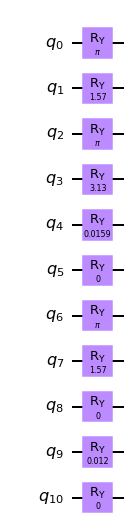

In [36]:
thetas = [2 * np.arcsin(np.sqrt(c_star)) for c_star in c_stars]

init_qc = QuantumCircuit(len(thetas))
for idx, theta in enumerate(thetas):
    init_qc.ry(thetas[idx], idx)

init_qc.draw(output='mpl')

After initializing the circuit with $R_Y$ rotations, I create the mixer operator for QAOA. Furthermore, the mixer operator must have its initial state as ground state when warm-starting QAOA. Therefore, the following Hamiltonian is chosen
$\begin{align}
H_{M,i}^{(ws)}= \begin{pmatrix}
2c_i^*-1 & -2\sqrt{c_i^*(1-c_i^*)} \\
-2\sqrt{c_i^*(1-c_i^*)} & 1-2c_i^*
\end{pmatrix}
\end{align}$
as the mixer operator for qubit $i$. After being multiplied by $-i\beta$ and exponentiated the mixer produces the mixer circuit below.

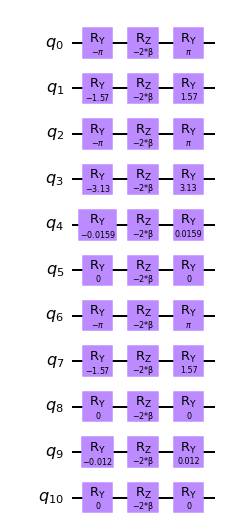

In [37]:
beta = Parameter('β')

ws_mixer = QuantumCircuit(len(thetas))
for idx, theta in enumerate(thetas):
    ws_mixer.ry(-theta, idx)
    ws_mixer.rz(-2 * beta, idx)
    ws_mixer.ry(theta, idx)

ws_mixer.draw(output='mpl')

Now passing the inital state and mixer operator to QAOA produces the identical result to the classical simulation, showing that warm-start QAOA provides benefits.

In [38]:
ws_qaoa_mes = QAOA(
    quantum_instance=qi,
    initial_state=init_qc,
    mixer=ws_mixer,
    initial_point=[0.0, 1.0],
)
ws_qaoa = MinimumEigenOptimizer(ws_qaoa_mes)
ws_qaoa_result = ws_qaoa.solve(qubo)

In [39]:
converted_ws_qaoa_result = convert_qubo_result(ws_qaoa_result, stock_tickers, share_limit)
print_converted_result(converted_ws_qaoa_result, budget, asset_costs)

Solution found with a $750.00 budget:

Total cost of assets to buy is $712.78
Stocks to buy are: 
	1 shares of AAPL at $280.27 per share
	3 shares of SPOT at $144.17 per share
	0 shares of MSFT at $160.07 per share


In [40]:
def format_qaoa_samples(samples, max_len: int=10):
    qaoa_res = []
    for s in samples:
        converted_s_x = convert_qubo_result(s, stock_tickers, share_limit)
        s_probability = s.probability
        qaoa_res.append([converted_s_x, s_probability])

    res = sorted(qaoa_res, key=lambda x: -x[1])[:max_len]

    return [(str(res_i[0] )+ f', probability: {100*res_i[1]:.1f}%') for res_i in res]

In [41]:
format_qaoa_samples(qaoa_result.samples)

["{'AAPL': 1, 'SPOT': 3, 'MSFT': 3}, probability: 0.7%",
 "{'AAPL': 2, 'SPOT': 1, 'MSFT': 3}, probability: 0.5%",
 "{'AAPL': 3, 'SPOT': 1, 'MSFT': 2}, probability: 0.5%",
 "{'AAPL': 2, 'SPOT': 2, 'MSFT': 1}, probability: 0.5%",
 "{'AAPL': 2, 'SPOT': 0, 'MSFT': 2}, probability: 0.5%",
 "{'AAPL': 3, 'SPOT': 3, 'MSFT': 3}, probability: 0.5%",
 "{'AAPL': 1, 'SPOT': 0, 'MSFT': 3}, probability: 0.5%",
 "{'AAPL': 2, 'SPOT': 2, 'MSFT': 1}, probability: 0.5%",
 "{'AAPL': 1, 'SPOT': 0, 'MSFT': 3}, probability: 0.5%",
 "{'AAPL': 1, 'SPOT': 0, 'MSFT': 0}, probability: 0.5%"]

In [42]:
format_qaoa_samples(ws_qaoa_result.samples)

["{'AAPL': 1, 'SPOT': 3, 'MSFT': 0}, probability: 27.1%",
 "{'AAPL': 3, 'SPOT': 3, 'MSFT': 0}, probability: 25.2%",
 "{'AAPL': 1, 'SPOT': 3, 'MSFT': 0}, probability: 23.9%",
 "{'AAPL': 3, 'SPOT': 3, 'MSFT': 0}, probability: 23.7%"]

As seen in these results, warm-starting QAOA generates more confident results with higher probability that are accurate to the classical solution. As quantum processers are developed to allow many more qubits, portfolio optimization can be done on with many stocks with more precision.